In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class NeuralStyleTransfer:
  def __init__(self, content_image_path, style_image_path, generated_image_path, learning_rate=0.001, alpha=1, beta=0.1):
    self.content_image   = Image.open(content_image_path)
    self.content_image   = torchvision.transforms.Resize((256, 256))(self.content_image)
    self.content_image   = (torchvision.transforms.ToTensor()(self.content_image)).unsqueeze(0).to(device)
    self.style_image     = Image.open(style_image_path)
    self.style_image     = torchvision.transforms.Resize((256, 256))(self.style_image)
    self.style_image     = (torchvision.transforms.ToTensor()(self.style_image)).unsqueeze(0).to(device)
    self.generated_image = Image.open(generated_image_path)
    self.generated_image = torchvision.transforms.Resize((256, 256))(self.generated_image)
    self.generated_image = (torchvision.transforms.ToTensor()(self.generated_image)).unsqueeze(0).to(device).requires_grad_()
    self.layer_nums      = [0, 5, 10, 19, 28]
    self.model           = torchvision.models.vgg19(pretrained=True).eval().features[:29].to(device)
    self.alpha           = alpha
    self.beta            = beta
    self.optim           = torch.optim.Adam([self.generated_image], lr = learning_rate)
    self.l2loss          = torch.nn.MSELoss()

  def generate_features(self, x):
    features = []
    for num, layer in enumerate(self.model):
      x = layer(x)
      if num in self.layer_nums:
        features.append(x)
    return features

  def loss(self, generated_features, content_features, style_features):
    content_loss = style_loss = 0
    for generated_feature, content_feature, style_feature in zip(generated_features, content_features, style_features):
      batch_size, channels, height, width = generated_feature.shape
      content_loss += self.l2loss(generated_feature, content_feature)

      G = generated_feature.view(channels, height*width).mm(generated_feature.view(channels, height*width).t())
      A = style_feature.view(channels, height*width).mm(style_feature.view(channels, height*width).t())
      style_loss += self.l2loss(G, A)

    return self.alpha*content_loss + self.beta*style_loss

  def train(self, num_steps):
    for step in range(num_steps):
      generated_features = self.generate_features(self.generated_image)
      content_features = self.generate_features(self.content_image)
      style_features   = self.generate_features(self.style_image)
      loss = self.loss(generated_features, content_features, style_features)
      self.optim.zero_grad()
      loss.backward()
      self.optim.step()

    return self.generated_image

In [12]:
nst = NeuralStyleTransfer('content_image.jpg','style_image.jpg','generated_image.jpg')

In [13]:
generated_image = nst.train(6000)

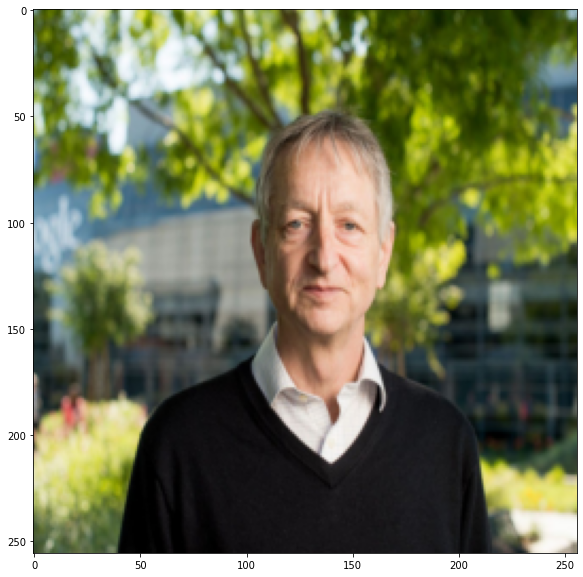

In [20]:
plt.rcParams["figure.figsize"] = (10,10)
content_image = nst.content_image.squeeze(0).permute(1,2,0).cpu().detach().numpy()
plt.imshow(content_image)

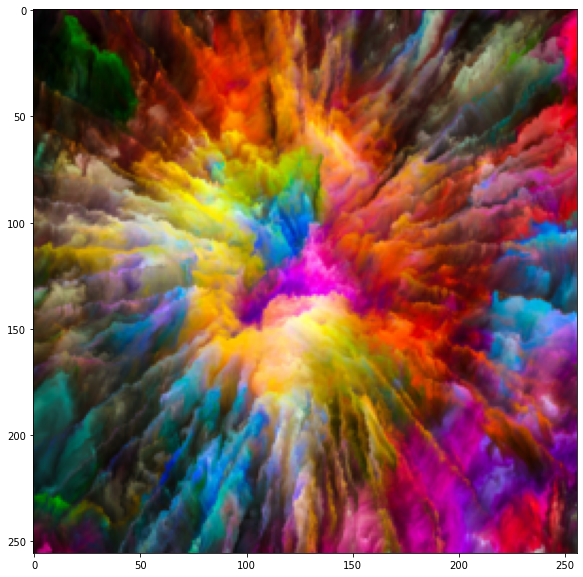

In [21]:
style_image = nst.style_image.squeeze(0).permute(1,2,0).cpu().detach().numpy()
plt.imshow(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


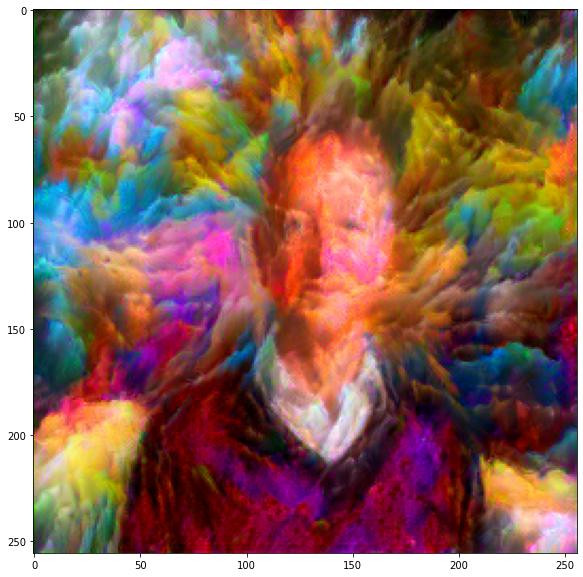

In [19]:
image = generated_image.squeeze(0).permute(1,2,0).cpu().detach().numpy()
plt.imshow(image)

In [17]:
torchvision.utils.save_image(generated_image,'new_generated_image.jpg')